# Tutorial: Personal Data

by Katharina Dost, University of Auckland

![Image](https://betterimagesofai.org/ImagesAI/jamillah-knowles_data-people_3952x2472.jpg?nf_resize=fit&w=1200&q=75)
[**Source:** <span><a href="https://www.jemimahknightstudio.com/work/ai">Jamillah Knowles</a> / <a href="https://www.betterimagesofai.org">Better Images of AI</a> / Data People / <a href="https://creativecommons.org/licenses/by/4.0/">Licenced by CC-BY 4.0</a></span>]

---

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

try:
    from pycanon import anonymity, report
except:
    !pip install pycanon
    from pycanon import anonymity, report
    
try:
    from diffprivlib.models import RandomForestClassifier as RandomForestClassifier_dp
except:
    !pip install diffprivlib
    from diffprivlib.models import RandomForestClassifier as RandomForestClassifier_dp
    
from diffprivlib.utils import PrivacyLeakWarning   
warnings.simplefilter(action='ignore', category=PrivacyLeakWarning)

---

## Examples and Risks
- Search history: What if I visit websites related to cancer, my insurance company learns about it and raises their rates?
- Credit card fraud: What if someone could ask a large language model for my credit card details and steal money from me?
- What if a burglar could connect easily connect my current vacation pictures with the information that I live alone and my address? [[read more](https://www.cnbc.com/2018/06/14/that-vacation-social-media-post-might-raise-the-risk-of-robbery.html)]
- Lecture Evaluations: What if my lecturer can trace my negative feedback back to me and gives me a bad grade?
- What if my medical history was openly known to, e.g., future employers?

---

## Privacy Attacks

There is a large number of reasons for adversaries to gain access to raw data -- a few of them are discussed above. However, recently, attacks are often focussed on machine learning models trying to extract sensitive information from model outputs. [[read more](https://dl.acm.org/doi/10.1145/3624010)]

Particularly, an adversary might want to use a trained model to:
- determine if a specific input sample was used for training or not. This type of "attack" can also be seen from a different perspective, for example, an artist might want to know if a generative model (such as DALL-E) used their artwork without authorization.
- recover the entire training data 
- recover specific sensitive attributes of a targeted user from model outputs
- extract dataset properties that were not directly encoded as features, for example, the gender ratio of a patient dataset even if it was not an attribute. This is an interesting approach to identify implicit bias in models.

---

## What is personal information?
> "Personal information is any information that tells us something about a **specific individual**. The information does not need to name the individual, as long as they are identifiable in other ways, like through their home address. This means that all sorts of things can contain personal information, including notes, emails, recordings, photos, and scans, whether they are in hard copy or electronic form." [[Source](https://www.privacy.org.nz/responsibilities/your-obligations/)]

For example, the following table contains personal data:

**Table 1**
| Customer ID | Age | Gender     | Occupation | Rating (1-5) | Feedback                              |
|-------------|-----|------------|------------|--------------|---------------------------------------|
| 001         | 35  | Female     | Engineer   | 4            | Great service!                        |
| 002         | 28  | Male       | Teacher    | 3            | Average experience                    |
| 003         | 42  | Male       | Doctor     | 5            | Excellent service, highly recommended|
| 004         | 50  | Female     | Lawyer     | 2            | Disappointing, needs improvement     |
| 005         | 31  | Non-binary | Student    | 4            | Very helpful staff                   |

The following table does **not** contain personal data:

**Table 2a**
| Transaction ID | Date       | Product    | Quantity | Price  |
|----------------|------------|------------|----------|--------|
| 1001           | 2024-04-15 | Laptop     | 2        | \$1200 |
| 1002           | 2024-04-16 | Smartphone | 3        | \$800  |
| 1003           | 2024-04-17 | Headphones | 1        | \$100  |
| 1004           | 2024-04-18 | Tablet     | 1        | \$500  |
| 1005           | 2024-04-18 | Smartwatch | 2        | \$300  |

**Note:** The following table in in itself is *not* considered personal data:

**Table 2b**
| Customer ID | Transaction ID | Date       | Product    | Quantity | Price  |
| ----------- |----------------|------------|------------|----------|--------|
| 001         | 1001           | 2024-04-15 | Laptop     | 2        | \$1200 |
| 001         | 1002           | 2024-04-16 | Smartphone | 3        | \$800  |
| 002         | 1003           | 2024-04-17 | Headphones | 1        | \$100  |
| 003         | 1004           | 2024-04-18 | Tablet     | 1        | \$500  |
| 003         | 1005           | 2024-04-18 | Smartwatch | 2        | \$300  |

However, if the customer IDs correspond to the ones in the Table 1, the transactions can be traced back to individuals and both tables together *are* considered personal data.

---

## Legal Frame

### New Zealand

In New Zealand, the [Privacy Act 2020](https://www.legislation.govt.nz/act/public/2020/0031/latest/LMS23223.html) rules how personal data can be collected, stored, used and shared. It applies to any person, organization, or business that collects and holds personal data. The only exceptions are courts and tribunals during judicial tasks, news media when gathering and reporting news, and members of the parliament acting in an official capacity [[Source](https://www.privacy.org.nz/responsibilities/your-obligations/)].

Every person has a right their personal information being **protected and respected** [[Source](https://www.privacy.org.nz/your-rights/your-privacy-rights/)]. This includes:
- they know when and why their information is collected
- their information is used and shared appropriately
- their information is kept safe and secure
- they can access the information and organization holds about them.

As an upcoming AI engineer / data scientist / machine learning expert / etc., you have a **responsibility to ensure these rights are met**. 

The Privacy Act has [13 privacy principles](https://www.privacy.org.nz/assets/New-order/Your-responsibilities/Privacy-resources-for-organisations/2020-A-quick-tour-of-the-privacy-principles-Oct-2020.pdf) on how to collect, handle, and use personal information. 
The university supports you with collecting data ([[Ethics Approval](https://www.auckland.ac.nz/en/research/about-our-research/human-ethics.html)] and handling data [[Planning research data storage](https://research-hub.auckland.ac.nz/guide-to-managing-research-data/research-data-management-or-storage-compute-and-analysis/research-data-management-plan-and-document-storage-and-analysis)]. 

### Other Countries

Other countries have their own regulations. Check carefully depending on your location and context. 
For example, there are a number of 
[Data Privacy Protection Laws](https://www.forbes.com/sites/conormurray/2023/04/21/us-data-privacy-protection-laws-a-comprehensive-guide/?sh=33d6e10c5f92) in the United States, 
the European [Right to be Forgotten](https://gdpr-info.eu/issues/right-to-be-forgotten/), and 
the European [General Data Protection Regulation (GDPR)](https://gdpr-info.eu/). 

---

## Example Dataset: Titanic

![Image](https://cdn.pixabay.com/photo/2021/03/04/16/43/ship-6068737_960_720.png)

The Titanic was a British passenger liner that tragically sank on its maiden voyage in 1912 after colliding with an iceberg, resulting in one of the deadliest maritime disasters in history.

We use a dataset taken from [Kaggle](https://www.kaggle.com/competitions/titanic/overview) that lists the Titanic's passengers and if they survived the disaster. We are using the training dataset only here. You can download it either from Kaggle directly or Canvas.

You will find the following columns in the dataset:
| Column | Definition | Key |
| ------ | ---------- | --- |
| PassengerId         | Passenger identifier |  |
| Survived         | Target label: Survival | 0 = No, 1 = Yes |
| Pclass         | Ticket class (a proxy for socio-economic status)          | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Name         | Passenger name           | |
| Sex         | Sex           |  |
| Age         | Age in years           | |
| SibSp         | \# of siblings / spouses aboard the Titanic         | |
| Parch         | \# of parents / children aboard the Titanic           | |
| Ticket         | Ticket number           | |
| Fare         | Passenger fare         | |
| Cabin         | Cabin number          | |
| Embarked         | Port of Embarkation          | C = Cherbourg, Q = Queenstown, S = Southampton|

In [4]:
# Have a look at the dataset
df = pd.read_csv('titanic_train_dataset.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
# let's make sure we do not lose sight of missing values
df = df.fillna(-1)

---

## Turning Personal Data into Non-Personal Data

The Privacy Act (or international equivalents) applies to *personal* data. If we ensure the definition for personal data no longer applies, the Privacy Act no longer applies. This grants us more freedom to work with the data. *Ethical considerations still apply!*

**Reminder: Definition "Personal Information"**
> "Personal information is any information that tells us something about a **specific individual**. The information does not need to name the individual, as long as they are identifiable in other ways, like through their home address. This means that all sorts of things can contain personal information, including notes, emails, recordings, photos, and scans, whether they are in hard copy or electronic form." [[Source](https://www.privacy.org.nz/responsibilities/your-obligations/)]

There are two types of identifiers:
1. *direct identifiers* that directly identify an individual, such as their name, address, telephone number, photograph, image, fingerprints, etc., and
2. *indirect identifiers* that can be combined with other information to identify an individual, such as all female students in the classroom whose birthday is in May that belong to a specific race or have a specific hair color..... These indirect identifiers are often referred to as *quasi-identifiers*.

In [6]:
# create a new dataframe that shall contain the anonymized data later
df_anon = df.copy()

---

### 1. Dealing with direct identifiers

What are the direct identifiers in the Titanic dataset?


<details>
<summary> (*click* here to reveal the answer) </summary>

**Name** is a direct identifier (unless, e.g., only people called "John Smith" were allowed to board the ship). This is a global identifier that can be found in other datasets, too, making this information particularly vulnerable. In New Zealand, you cannot use such identifiers according to [Privacy Act, Principle 14](https://www.privacy.org.nz/privacy-act-2020/privacy-principles/13/).
    
**Ticket** is a direct identifier if there exists another table linking ticket purchases to individuals. If it only exists in this table, it is okay.
    
Similarly, **Cabin** can be a direct identifier, if there exists another table linking it to, for example, the passenger's name. 
    
**PassengerID** can be a direct identifier, too, if there exists another table linking it to, for example, the passenger's name. 
</details>

#### 1.1 Hashing

When in doubt about the identifiers in your dataset you can use a one-way [hash function](https://en.wikipedia.org/wiki/Hash_function) using the [hashlib package](https://docs.python.org/3/library/hashlib.html) to create unique identifiers from direct identifiers that cannot be traced back to the direct identifiers. 

**If you have to**, you can create a table or dictionary to store the mapping from direct identifier to hashed identifier. Keep in mind that this table/dictionary *is sensitive* and needs to be safe-guarded.

In [7]:
# create hashed IDs from 'Name' column
df_anon['HashID'] = df_anon['Name'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest()[:8])
df_anon.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HashID
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,-1,S,6c969dc7
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,f7ad2d69
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,-1,S,7eb1fa77
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,c8a06e74
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,-1,S,885e53ea


In [8]:
# if you need to, create a table mapping HashID to sensitive information
HashID_to_direct_identifiers = df_anon[['HashID', 'PassengerId', 'Name', 'Ticket']]
HashID_to_direct_identifiers.head()

# write this table to file and keep it safe!

,HashID,PassengerId,Name,Ticket
0,6c969dc7,1,"Braund, Mr. Owen Harris",A/5 21171
1,f7ad2d69,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599
2,7eb1fa77,3,"Heikkinen, Miss. Laina",STON/O2. 3101282
3,c8a06e74,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803
4,885e53ea,5,"Allen, Mr. William Henry",373450


In [9]:
# drop the direct identifiers
df_anon = df_anon.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

---

#### 1.2 Removing direct identifiers

If you work on this table alone without the need to join it to another table, you can omit the direct identifiers entirely. 

In [10]:
# drop the hashID
df_anon = df_anon.drop(['HashID'], axis=1)
df_anon.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,-1,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,-1,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,-1,S


---

#### 1.3 Aggregation

Sometimes, there are column values that appear only once and therefore uniquely identify a person. For example:

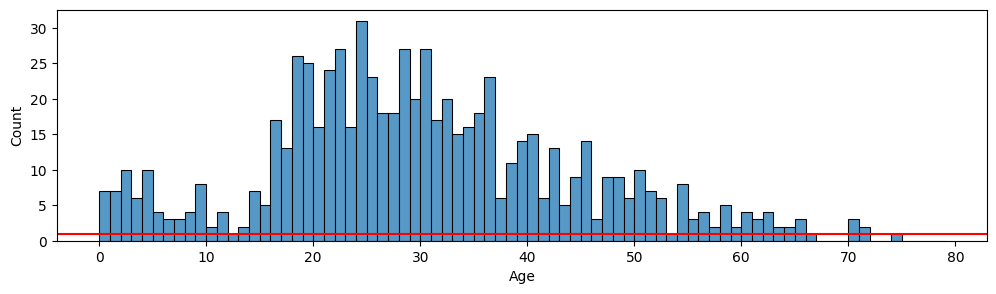

In [11]:
plt.figure(figsize=(12, 3))
sns.histplot(data=df_anon, x='Age', bins=range(0, 80, 1), kde=False)
plt.axhline(1, c='red')

There are many ways to deal with this, and you need to choose which one makes the most sense in your scenario:
- Delete the column (rarely useful)
- Data masking: Introduce a masking key such as "\*" and insert that into each entry that causes this identification problem (information loss, and sometimes, "\*" can also single out individuals)
- Aggregation: group values into categories (popular approach)

In [12]:
# Aggregation: Anonymize the age by grouping values
bins = [-100, 0, 18, 30, 45, 100]
labels = ['missing', '0-18', '19-30', '31-45', '45+']
df_anon['Age'] = pd.cut(df_anon['Age'], bins=bins, labels=labels)

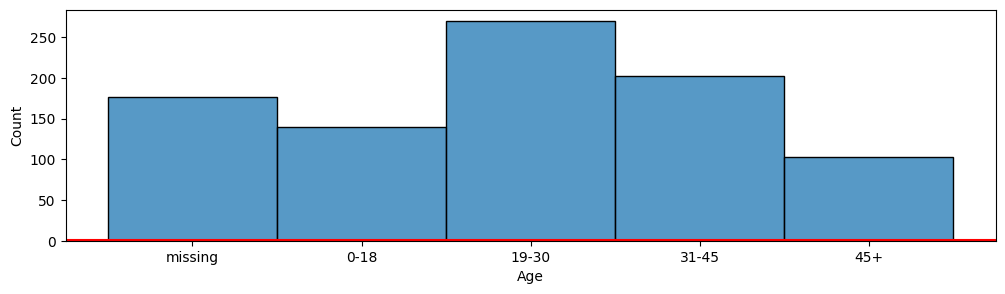

In [13]:
plt.figure(figsize=(12, 3))
sns.histplot(data=df_anon, x='Age', bins=range(0, 80, 1), kde=False)
plt.axhline(1, c='red')

As we can see, the problem of singling someone out based on 'Age' has been solved.

Another example for aggregation is the 'Cabin'. From a machine learning perspective, the cabin number itself will not inform the model well, but the floor on which it is situated may be a proxy for the traveler's social status. We can aggregate the cabins to retain only this information.

In [14]:
# Aggregate 'Cabin' by extracting the first character
df_anon['Cabin'] = df_anon['Cabin'].astype(str).str[0]

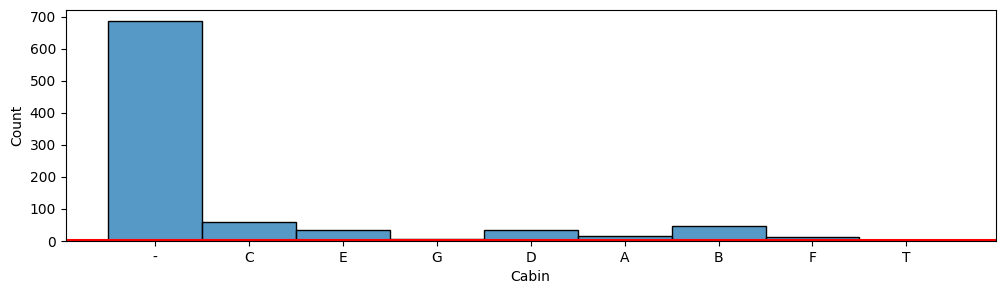

In [15]:
plt.figure(figsize=(12, 3))
sns.histplot(data=df_anon, x='Cabin', bins=range(0, 80, 1), kde=False)
plt.axhline(1, c='red')

We observe that this aggregation is not sufficient. If we had more information regarding the cabin, we could aggregate further in a meaningful way. Since we do not, we will drop the column.

In [16]:
# drop the Cabin
df_anon = df_anon.drop(['Cabin'], axis=1)
df_anon.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,19-30,1,0,7.2500,S
1,1,1,female,31-45,1,0,71.2833,C
2,1,3,female,19-30,0,0,7.9250,S
3,1,1,female,31-45,1,0,53.1000,S
4,0,3,male,31-45,0,0,8.0500,S


---

#### 1.4 Other types of data

In our case, dropping the columns was an easy choice and will not harm our machine learning model. However, this can be different depending on our dataset! 

Consider, for example, a dataset of MRI images that you want to use to learn detecting tumors. Generative AI can reconstruct facial images from these MRIs and thereby identify individuals. [[read more](https://www.diva-portal.org/smash/get/diva2:1359959/FULLTEXT01.pdf)]

Even if you choose to reduce the quality of your images, AI is able to reconstruct faces. [[read more](https://arxiv.org/pdf/1702.00783.pdf)]

Similarly, recordings (speech) can be used to identify individuals. [[read more](https://openaccess.thecvf.com/content_CVPR_2019/papers/Oh_Speech2Face_Learning_the_Face_Behind_a_Voice_CVPR_2019_paper.pdf)]  

**Strategy for audio/visual/text/geospatial data** (in accordance with [this](https://hackmd.io/@eglerean/anonfeb2023) fantastic workshop):
- Video
    - Delete the video if it's not necessary
    - Blur the faces if the video is necessary, e.g., in Python with [deface](https://pypi.org/project/deface/), [OpenFace](http://multicomp.cs.cmu.edu/resources/openface/), [openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) or [deepfakes](https://github.com/hukkelas/DeepPrivacy)
- Audio (speech)
    - Convert to text transcript if the speech is not necessary, e.g., locally with [DeepSpeech](https://deepspeech.readthedocs.io/en/r0.9/?badge=latest)
    - Anonymize, e.g., with [lightweight_spkr_anon](https://github.com/sarulab-speech/lightweight_spkr_anon)
    - Store preprocessed data, e.g., with [Whisper](https://openai.com/research/whisper)
- Text (such as video/speech transcript)
    - De-identify your text, e.g., using [presidio](https://github.com/microsoft/presidio), [OpenRedact](https://github.com/openredact), or [CRF NER](https://nlp.stanford.edu/software/CRF-NER.html)
    - Specifically for free-text medical records: [MIST](https://mist-deid.sourceforge.net/)
- Geospatial data
    - [read paper](https://www.sciencedirect.com/science/article/pii/S0198971520302465#f0010)
- MRI data
    - defacing with [mri_deface](https://surfer.nmr.mgh.harvard.edu/fswiki/mri_deface)
    
**GUI-Based tools for tabular data:**
- [Amnesia](https://amnesia.openaire.eu/amnesia/index.html) (with [documentation](https://amnesia.openaire.eu/about-documentation.html))
- [ARX](https://arx.deidentifier.org/) (with [demo](https://www.youtube.com/channel/UCcGAF5nQ_O6ResEF-ivsbVQ/videos))
    
Whatever you use, be careful with Cloud Services as they may violate the privacy regulations you are under -- check carefully. 

---

### 2. Dealing with indirect identifiers

<img align="left" width="200" src="https://upload.wikimedia.org/wikipedia/en/0/08/Guess_who_game_cover.jpg" />


#### "Guess Who" game

Individuals can be singled out using only 4 yes/no questions regarding their appearance, e.g., "Does the character have red hair / white skin / a hat?"

*Similarly, individuals can often be re-identified in datasets using a combination of indirect identifiers.*

[Source: [Wikipedia](https://en.wikipedia.org/wiki/Guess_Who%3F)]

---

#### 2.1 Masking

Individuals might still be identifiable due to combinations of columns.
For example:

In [17]:
df_anon.groupby(['Pclass', 'Embarked', 'Sex']).size().unstack(fill_value=0)

Sex              female  male
Pclass Embarked              
1      -1             2     0
       C             43    42
       Q              1     1
       S             48    79
2      C              7    10
       Q              2     1
       S             67    97
3      C             23    43
       Q             33    39
       S             88   265

One way to deal with this is **Masking**, where we assign different values to identifiers to hinder re-identification. For example, instead of directly advising the embarkation port, we can mask this information:

In [18]:
# Masking the 'Embarked' column with made-up port names
masking_dictionary = {'C': 1, 'Q': 2, 'S': 3}
df_anon = df_anon.replace({'Embarked': masking_dictionary})
df_anon.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,19-30,1,0,7.2500,3
1,1,1,female,31-45,1,0,71.2833,1
2,1,3,female,19-30,0,0,7.9250,3
3,1,1,female,31-45,1,0,53.1000,3
4,0,3,male,31-45,0,0,8.0500,3


*Be careful with masking!* Re-mapping of the original name is frequently possible. In the 'Embarkation' example, consider the distribution of ticket classes and ports:

In [19]:
df_anon.groupby(['Pclass', 'Embarked']).size().unstack(fill_value=0)

Embarked,-1,1,2,3
Pclass,,,,
1,2,85,2,127
2,0,17,3,164
3,0,66,72,353


A skilled reader might know that the biggest crowd embarked in Southampton and that upper-class travelers did not come from Queenstown. With this knowledge, they can remap the masked values to the original ones. Meanwhile, interpreting the dataset becomes more difficult.

---

#### 2.2 Deleting identifiable data

In some cases, it makes sense to delete identifiable data if only few entries are affected. This is a reasonable approach in machine learning since learned models will likely discard these singletons as noise. If these cases are important to your application, you should not delete them.

---

#### 2.3 Testing privacy: Manually

You will need to test repeatedly, if your anonymization is sufficient or if you need to do more. 

One option (if you have a small number of columns) is to test manually:

<Figure size 200x200 with 0 Axes>

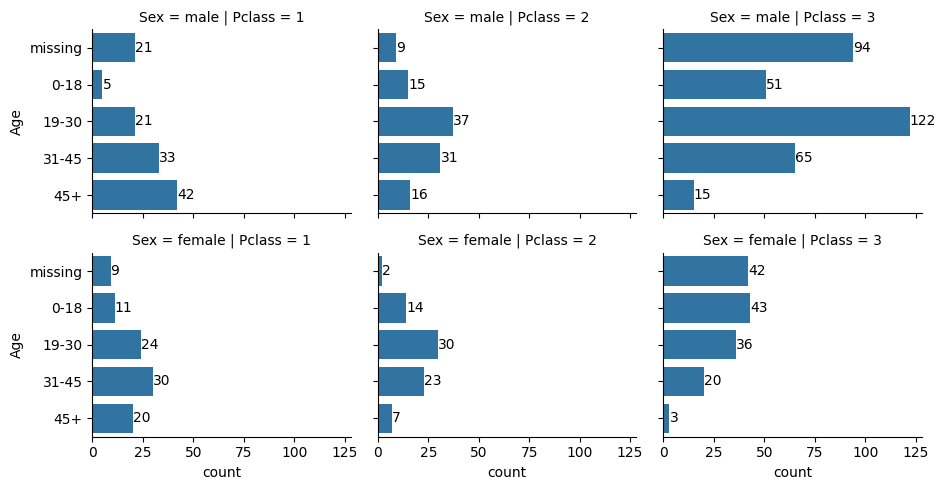

In [20]:
plt.figure(figsize=(2, 2))
g = sns.catplot(data=df_anon, y='Age', col='Pclass', row='Sex', kind='count', height=2.5, aspect=1.25)

# add bar annotations
for ax in g.axes.flat:
    for c in ax.containers:
        labels = [f'{v.get_width():.0f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.show()

A more automated option is to test using the [pycanon](https://pycanon.readthedocs.io/en/stable/intro.html) package. [[read paper](https://www.nature.com/articles/s41597-022-01894-2)]

**k-Anonymity:**

A *quasi-identifier* is an attribute whose release must be controlled because it may, in combination with others, lead to the identification of an individual. 

*k-Anonymity* is satisfied if and only if every possible combination of values of quasi-identifiers has at least *k* records in the dataset.

In [21]:
quasi_identifiers = ['Pclass', 'Sex', 'Age']
k = anonymity.k_anonymity(df_anon, quasi_identifiers)
k

2

We can see that the definition of k-Anonymity leads to the same result as the above manual analysis, not taking any of the other columns into account. However, when adding additional columns, the k-Anonymity drops to 1. 

In [22]:
quasi_identifiers = list(df_anon.columns)
k = anonymity.k_anonymity(df_anon, quasi_identifiers)
k

1

---

#### 2.4 PCA-based Privacy

One popular approach to enhance privacy while retaining crucial information for machine learning is to transform the dataset using [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). [[read more](https://blogs.ed.ac.uk/datasciencecdt/2020/03/31/using-pca-to-preserve-privacy/)]

PCA is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional space while preserving as much variance as possible. It identifies the principal components, which are orthogonal linear combinations of the original features, allowing for simplified data representation and visualization. 

By representing the data in a more compact form, PCA can help mitigate the risk of re-identification and protect sensitive information, making it more challenging for adversaries to infer individual identities from the transformed data. Additionally, PCA does not rely on individual feature values, making it harder for attackers to reconstruct the original data and preserve the privacy of individuals.

In [23]:
# Define columns we'd like to replace using PCA
columns_to_replace_with_pca = ['SibSp', 'Parch', 'Fare', 'Embarked']

# initialize pca object. n_components=0.95 chooses the number of components 
# such that at least 99% of the information is captured despite the dimensionality 
# reduction
pca = PCA(n_components=0.99, svd_solver='full')
transformed_columns = pca.fit_transform(df_anon[columns_to_replace_with_pca])

# merge new column
df_anon['SibSp+Parch+Fare+Embarked'] = transformed_columns

# drop replaced columns
df_anon = df_anon.drop(columns_to_replace_with_pca, axis=1)

df_anon.head()

,Survived,Pclass,Sex,Age,SibSp+Parch+Fare+Embarked
0,0,3,male,19-30,-24.955143
1,1,1,female,31-45,39.084417
2,1,3,female,19-30,-24.283701
3,1,1,female,31-45,20.893963
4,0,3,male,31-45,-24.158704


**Note:** From a machine learning perspective, the PCA transformation has captured most of the information that was contained in the columns -- no major problem. However, the dataset is substantially less interpretable than before. You will need to decide if this is worth it based on your application.

Except for PCA, researchers have also used other methods to transform features in a smilar fashion, including clustering, other dimensionality reduction techniques, and transformation into embedding space.

---

#### 2.5 Differential Privacy

[Differential privacy](https://link.springer.com/chapter/10.1007/11787006_1) is a framework for protecting the privacy of individuals in datasets while allowing useful insights to be extracted from the data. This makes it an ideal pre-processing step for machine learning purposes, and it is in fact the state-of-the-art. 

> Roughly, an algorithm is differentially private if an observer seeing its output cannot tell whether a particular individual's information was used in the computation. [[Source](https://en.wikipedia.org/wiki/Differential_privacy#cite_note-hilton08-1)]

Differential privacy achieves this by adding carefully calibrated noise or randomness to the data, ensuring that the statistical properties of the data are preserved while obscuring the contribution of any specific individual. 

Differential privacy also involves concepts such as privacy budget, which quantifies the amount of privacy loss that can occur over multiple queries or analyses, and compositionality, which ensures that the privacy guarantees hold even when multiple analyses or queries are performed on the same dataset.

There are multiple packages in Python that implement differential privacy:
- [PyDP](https://pydp.readthedocs.io/en/latest/index.html) is a Python wrapper for Google's [Differential Privacy](https://github.com/google/differential-privacy) project
- IBM's [Diffprivlib](https://github.com/IBM/differential-privacy-library) with documentation [[here](https://diffprivlib.readthedocs.io/en/latest/index.html)], which offers algorithms similar to sklearn but with differential privacy. We will use this package below in a comparison.

The main advantage of Differential Privacy is that it provides **provable privacy guarantees**.

---

## Privacy vs. Accuracy Trade-Off

There is a delicate balance between preserving individual privacy and maintaining the utility or accuracy of data analysis or machine learning models. De-identifying personal data is an iterative approach that consists of a series of decisions effectively trading accuracy for privacy. 

Let's find out what price we had to pay for our anonymization.

---

### Step 1: Numeric format

Since scikit-learn mostly cannot deal with categorical data, we convert the original and anonymized dataset into numeric format. This is a technical pre-processing step that does not lose any information -- for each column, we convert the first unique value we find to 0, the second one to 1, etc.

In [24]:
df_num = df.copy()
# drope the unique identifiers since ML will not be able to learn from them
df_num = df_num.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# get all non-numeric columns
non_numeric_columns = df_num.select_dtypes(exclude=['number']).columns.tolist()

# convert to numeric columns:
#   0 = the first unique value, 1 = the second unique value, etc.
for column in non_numeric_columns:
    df_num[column] = pd.factorize(df_num[column])[0]
    
df_num.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


In [25]:
df_anon_num = df_anon.copy()

# get all non-numeric columns
non_numeric_columns = df_anon_num.select_dtypes(exclude=['number']).columns.tolist()

# convert to numeric columns:
#   0 = the first unique value, 1 = the second unique value, etc.
for column in non_numeric_columns:
    df_anon_num[column] = pd.factorize(df_anon_num[column])[0]
    
df_anon_num.head()

,Survived,Pclass,Sex,Age,SibSp+Parch+Fare+Embarked
0,0,3,0,0,-24.955143
1,1,1,1,1,39.084417
2,1,3,1,0,-24.283701
3,1,1,1,1,20.893963
4,0,3,0,1,-24.158704


---

### Step 2: Training/Test split and Training

As a second step, we split both datasets consistently into training and test set. We make sure to create exactly the same splits for a fair comparison.

In [26]:
def run_test(df, kf, clf, param_grid):
    accuracies = []

    for i, (train_index, test_index) in enumerate(kf.split(range(len(df)))):

        X_tr = df.loc[:, df.columns != 'Survived'].drop(test_index)
        y_tr = df['Survived'].drop(test_index)
        X_te = df.loc[:, df.columns != 'Survived'].drop(train_index)
        y_te = df['Survived'].drop(train_index)
        
        grid_search = GridSearchCV(estimator=clf(), param_grid=param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_tr, y_tr)
        
        clf_best = clf(**grid_search.best_params_)
        clf_best.fit(X_tr, y_tr)
        acc = clf_best.score(X_te, y_te)
        accuracies.append(acc)
        print(acc)
    print('Average:', np.average(accuracies), '+/-', np.std(accuracies))

In [27]:
kf = KFold(n_splits=5, random_state=1234, shuffle=True)
clf = RandomForestClassifier
param_grid = {
    'n_estimators': [10, 20, 30, 50, 100],
    'max_depth': [5, 10, 20]
}

print('Accuracy on the original dataset:\n==========')
run_test(df_num, kf, clf, param_grid)

print('\nAccuracy on the manually anonymized dataset:\n==========')
run_test(df_anon_num, kf, clf, param_grid)

clf = RandomForestClassifier_dp
param_grid = {
    'n_estimators': [10, 20, 30, 50, 100],
    'max_depth': [5]  # we hardcode the max_depth here to speed up the calculations.
                      # This is not a fair comparison!! If you run this test in a real
                      # application, make sure to use the same parameter range!
}
print('\nAccuracy with differential privacy:\n==========')
run_test(df_num, kf, clf, param_grid)

Accuracy on the original dataset:
0.8379888268156425
0.8258426966292135
0.8033707865168539
0.7528089887640449
0.8370786516853933
Average: 0.8114179900822297 +/- 0.0318506627822089

Accuracy on the manually anonymized dataset:
0.8268156424581006
0.8033707865168539
0.8033707865168539
0.7696629213483146
0.848314606741573
Average: 0.8103069487163392 +/- 0.02632594420122576

Accuracy with differential privacy:
0.770949720670391
0.7528089887640449
0.7696629213483146
0.7640449438202247
0.7921348314606742
Average: 0.76992028121273 +/- 0.012821295887354275


In conclusion, we observe that there is a price to pay for privacy. We got lucky with our manual anonymization approach since this is a rather simple dataset, but we cannot expect this to always be the case in practice. 

Differential privacy, on the other hand, comes with privacy guarantees and is therefore recommended!

---

## Take Home Message

![Image](https://betterimagesofai.org/ImagesAI/jamillah-knowles_we-and-ai_ivory-tower-ai-2_3337x2434.jpg?nf_resize=fit&w=640&q=75)
[**Source:** <span><a href="www.jemimahknightstudio.com/work/ai">Jamillah Knowles</a> & <a href="undefined">We and AI</a> / <a href="https://www.betterimagesofai.org">Better Images of AI</a> / People and Ivory Tower AI 2 / <a href="https://creativecommons.org/licenses/by/4.0/">Licenced by CC-BY 4.0</a></span>]

- Leaking personal data can have severe consequences.
- Collecting personal data is tricky and needs thorough planning. Gather only what you need for a well-defined purpose, make sure to get the participants permission, and store the data safely. It is your responsibility to keep it safe and obey the appropriate laws.
- Data anonymization, if perfect (which is hard to achieve), frees you of personal data protection obligations, but not of your standard of ethics. 
- There is no one-fits-all procedure to anonymize data -- you have to choose based on the use case.
- It helps to try and re-identify data to find problems with the anonymization (and then fix them).
- There is a trade-off between privacy and accuracy. Your model is most accurate with fully visible data (-> 0 privacy) whereas privacy is maximized when the data is simply deleted (-> 0 accuracy). 

---

## More practice?

If you are keen to practice further, have a look at the following datasets on Kaggle:
- [2023 Celebrity Net Worth](https://www.kaggle.com/datasets/monkeybusiness7/2023-celebrity-net-worth) 
- [Animal Crossing Villagers](https://www.kaggle.com/datasets/jessicali9530/animal-crossing-new-horizons-nookplaza-dataset?resource=download&select=villagers.csv) (make sure to download villagers.csv, not the entire catalog)

---

## Readings

- A case study of anonymization of medical surveys [[link](https://chato.cl/papers/gentili_hajian_castillo_2017_anonymization_medical_survey_data_privacy.pdf)]
- Diffprivlib (IBM Differential Privacy package) paper outlining the features contained in the package [[link](https://arxiv.org/abs/1907.02444)]
- A fantastic review of privacy attacks with a focus on machine learning [[link](https://dl.acm.org/doi/10.1145/3624010)]